# AI Learns Chrome T-Rex Game!

In [98]:
"""
Lets import these babies
"""

# Bread and butter of any DL Problem
import numpy as np
from numpy import genfromtxt
from matplotlib import pyplot as plt

# For Automating browser actions
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys

# Importing Pytorch
import torch
import torch.nn as nn
import torch.optim as optim

# Now this is random
import random

# Collections
from collections import namedtuple

# For image processing
import cv2

# Just because I can't do math
import math

# Yeah this is the time stone
import time

import pyautogui

import matplotlib

from tqdm import tqdm

In [99]:
# Setting up display
%matplotlib inline
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display


In [100]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward', 'done')
)

e = Experience(1, 2, 3, 5, True)
e

Experience(state=1, action=2, next_state=3, reward=5, done=True)

In [101]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0

    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

    def len(self):
        return len(self.memory)



class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay, num_episodes):
        self.start = start
        self.end = end
        self.decay = decay
        self.num_episodes = num_episodes
        self.epsilon_decrements = np.linspace(self.start, self.end, self.num_episodes)

    def get_exploration_rate(self, current_episode):
        """exploration_rate = self.start + (self.end-self.start) *\
                      math.exp(-1. * current_episode * self.decay)"""
        # exploration_rate = self.start - current_episode * self.decay
        # return max(exploration_rate, self.end) 
        return self.epsilon_decrements[current_episode]



In [102]:
class Agent():
    
    def __init__(self, strategy, num_actions, device):
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
    
    def select_action(self, state, policy_net, current_episode):
        rate = self.strategy.get_exploration_rate(current_episode)
        # print(f"Exploration rate is {rate}")
        if rate <= random.random():
            # Exploration
            return random.randrange(self.num_actions)
        else:
            # Exploitation
            with torch.no_grad():
                # print(f"The agent has decided to take action #{policy_net(state).argmax(dim=1)}")
                q_values = policy_net(state)
                action = q_values.argmax(dim=1).item()
                return action




# This is our Enviroment manager 
chrome_browser_path = ".//Driver/chromedriver.exe"
init_script = "document.getElementsByClassName('runner-canvas')[0].id = 'runner-canvas'"
game_url = 'chrome://dino'

class ChromeManager():
    def __init__(self, device):
        self.device = device
        self.done = False
        self.initialize_chrome()
        self.get_state = ImagePreProcessing(self.driver, device)
    
    def initialize_chrome(self):
        chrome_options = Options()
        chrome_options.add_argument("start-maximized")
        chrome_options.add_argument("disable-infobars")
        chrome_options.add_argument("--mute-audio")
        self.driver = webdriver.Chrome(executable_path=chrome_browser_path, chrome_options=chrome_options)

    # Restarting our game
    def reset(self):
        try:
            self.driver.get(game_url)
        except:
            pass
            # print('Environment has been reset')
        self.driver.execute_script("Runner.config.ACCELERATION=0")
        self.driver.execute_script(init_script)
        return self.driver.execute_script("return Runner.instance_.restart()")

    # To close the game
    def close(self):
        return self.driver.execute_script("return Runner.instance_.crashed")

    # crash
    def get_crashed(self):
        return self.driver.execute_script("return Runner.instance_.crashed")

    # Start?
    def start(self):
        try:
            self.driver.get(game_url)
        except:
            pass
            # print('Exception has been handled')
        self.driver.execute_script('Runner.instance_.playing=true')
        self.press_up()
        # time.sleep(3)

    # To get the current score of our game
    def get_score(self):
        score_array = self.driver.execute_script("return Runner.instance_.distanceMeter.digits")
        # print(f"The Value of score is {score_array}")
        # Scores are stored in the form '0, 1, 4', for a score of 14.
        score = ''.join(score_array)
        if score is '':
            score = 0
        return int(score)

    # To get the highscore of our game
    def get_highscore(self):
        highscore_array = self.driver.execute_script('return Runner.instance_.distanceMeter.highScore')
        for i in range(len(highscore_array)):
            if highscore_array[i] == 0:
                break
            highscore_array = highscore_array[i:]
            highscore = ''.join(highscore_array)
            return int(highscore)
    
    # This function will be called when we want to jump
    def press_up(self):
        self.driver.find_element_by_tag_name('body').send_keys(Keys.ARROW_UP)

    # This function will be called when we want to duck
    def press_down(self):
        pyautogui.keyDown("down")
        time.sleep(0.2)
        pyautogui.keyUp("down")
        # self.driver.find_element_by_tag_name('body').send_keys(Keys.ARROW_DOWN)

    # This function will be called when we don't want to jump or duck
    def press_right(self):
        self.driver.find_element_by_tag_name('body').send_keys(Keys.ARROW_RIGHT)

    # Taking actions
    def take_action(self, action):
        score = self.get_score()
        highscore = self.get_highscore()
        reward = 1
        if action == 0:
            # T-Rex Jumps
            self.press_up()
        elif action == 1:
            # T-Rex ducks
            self.press_down()
        elif action == 2:
            # T-Rex procrastinates
            self.press_right()

        state = self.get_state.screenshot()
        self.done = False
        if self.get_crashed():
            # print("Is this condition being executed?")
            time.sleep(0.1)
            reward = -10
            self.done = True
            # print(f"Lmao we are {self.done}")
        # print(f"From the insides it looks like we are crashed? {self.done}")
        return state, reward, self.done, score, highscore
        


    # Hard stop
    def close_all(self):
        self.driver.close()
        self.driver.quit()
        try:
            os.system('cmd /c taskkill /F /IM chromedriver.exe')
        except:
            print('No tasks found!')


class EnviromentManager():
    def __init__(self, agent, environment):
        self.agent = agent
        self.environment = environment


class ImagePreProcessing():
    def __init__(self, driver, device):
        self.driver = driver
        self.device = device

    # Take Screenshot. We'll be needing 4 screenshots, so yeah
    def screenshot(self):
        file_path = './/Screenshots/'
        current_state = []
        for i in range(1, 5):
            file_name = file_path + 'Screenshot' + str(i) + '.jpg'
            screen_shot = pyautogui.screenshot(region=(0, 400, 1920, 330))
            screen_shot.save(file_name)
            image_tensor = self.process_image(file_name)
            current_state.append(image_tensor)
        current_state = torch.cat(current_state).unsqueeze(0).to(self.device)
        # print('THis marks the end of th capturing process')
        return current_state

    
    def process_image(self, image_file):
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image[image>255] = 255
        image = cv2.resize(image, (128, 64))
        image = np.reshape(image, (1, 128, 64))
        #image = torch.from_numpy(image)
        return self.image_to_tensor(image)


    def image_to_tensor(self, image):
        imag = image.astype(np.float32)
        image_tensor = torch.from_numpy(image)
        image_tensor = image_tensor.to(self.device, dtype=torch.float32)
        return image_tensor


    

In [103]:

# Starting to Build our DQN
class DinoNetwork(nn.Module):
    def __init__(self):
        super(DinoNetwork, self).__init__()
        self.number_of_actions = 3
        self.gamma = 0.99
        self.initial_epsilon = 0.1
        self.final_epsilon = 0.0001
        self.number_of_iterations = 10000
        self.replay_memory_size = 1000
        self.minibatch_size = 1 

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=32, kernel_size=5, stride=3),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 5, 3),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, 3),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(512, 64),
            nn.ReLU(),
            # nn.BatchNorm1d(256)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(64, 3),
            nn.Sigmoid()
        )


    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        # print(f"After last conv layer, shape is {x.shape}")
        x = x.flatten(start_dim=1, end_dim=-1)
        # print(f"After Flattening shape is {x.shape}")
        x = self.fc1(x)
        x = self.fc2(x) 
        return x


# Initalizing weights because it's cool
def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity='relu') 

In [104]:
# Defining Hyperparameters
batch_size = 256

# Discount factor for Belmann equation
gamma = 0.99

# Start value of the exploration rate
eps_start = 0.9

# End value of the exploration rate
eps_end = 0.01

# Decay rate to decay decay epsilon over time
eps_decay = 0.005

# How frequently the weights of target Network will be updated, in terms of episodes
target_update = 30

# Capacity of replay memory
memory_size = 10_000

# Learning rate of policy network
lr = 0.00001

# Total number of episodes, dumbo
num_episodes = 2000

# Setting up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setting loss
criterion = nn.MSELoss()

# Setting score
init_score = 100
final_score = 1000


In [105]:
# Environment goes brr

environ = ChromeManager(device=device)

# Strategy goes brr
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, num_episodes)

# Agent goes brr
agent = Agent(strategy, 3, device)

# Replay memory goes brr
memory = ReplayMemory(memory_size)

# Defining our Policy network and target network
policy_net = DinoNetwork().to(device)
policy_net.apply(init_weights)
target_net = DinoNetwork().to(device)

# For taking screenshots
get_ss = ImagePreProcessing(environ.driver, device)

# Now we set the weights of our target net to be the same as our policy net
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# Choosing our optimizer
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

"""environ.reset()
environ.start()
state = get_ss.screenshot()
environ.close_all()"""


'environ.reset()\nenviron.start()\nstate = get_ss.screenshot()\nenviron.close_all()'

In [106]:
"""
We will be defining some utility functions here
"""

# 
def extract_tensors(experiences):
    # Converting batches of exp to exp of batches
    batch = Experience(*zip(*experiences))
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.next_state)
    t4 = torch.cat(batch.reward)
    t5 = torch.cat(batch.done)

    return (t1, t2, t3, t4, t5)

# Saving a model at a checkpoint
def save_ckp(state):
    f_path = ".//saved_model/model_fixed_reward.pt"
    torch.save(state, f_path)


# Loading a model at a saved checkpoint
def load_ckp(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer

# Plotting network progress
def plot(values, average_loss):
    x = [i for i in range(len(values))]
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(x, values)
    plt.plot(average_loss)
    print(f"Episode: {len(x)}\tAverage_loss: {average_loss}")    
    plt.pause(0.001)
    if is_ipython: display.clear_output(wait=True)


In [107]:
agent_loss = []
def train(policy_net, target_net, optimizer, load=False, f_path=None, device='cpu'):
    if load:
        policy_net, optimizer = load_ckp(f_path, policy_net, optimizer)
        policy_net = policy_net.to(device)
        target_net.load_state_dict(policy_net.state_dict())
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(device)
   
    possible_actions = ['Jump', 'Duck', 'Do Nothing']

    # Resetting the env
    environ.reset()
    environ.start()
    for episode in tqdm(range(num_episodes)):
        # Starting a new episode
        pyautogui.press('enter')
        time.sleep(3)

        # Capturing screenshots
        state = get_ss.screenshot()
        done = False
        # While the episode is running
        # print(type(done))
        while not done:
            # print(type(done))
            action = agent.select_action(state, policy_net, episode)
            # print(f"The agent decided to {possible_actions[action]}")
            next_state, reward, done, score, highscore  = environ.take_action(action)
            time.sleep(0.1)
                      
            # Converting action, reward, done to Pytorch tensors
            action_tensor = torch.tensor(action, dtype=torch.int64, device=device)
            reward_tensor = torch.tensor(reward, dtype=torch.int16, device=device)
            done_tensor = torch.tensor(done, dtype=torch.bool, device=device)
            #print(f"After changing, action :{type(action_tensor)}\ndone: {type(done_tensor)}\treward: {type(reward_tensor)}")
            memory.push(Experience(state, action_tensor.unsqueeze(0), next_state, reward_tensor.unsqueeze(0), done_tensor.unsqueeze(0)))
            

            # print(f"action: {action_tensor}\treward: {reward_tensor}\ndone: {done_tensor}")
            
            """if memory.can_provide_sample(batch_size):
                experiences = memory.sample(batch_size)
                states, actions, rewards, next_states = extract_tensors(experiences)"""
            # print(f"batch size is {batch_size} an memory size is {memory_size}, and currently we have {memory.len()} samples. So we can provide samples? {memory.can_provide_sample(batch_size)}")
            if memory.can_provide_sample(batch_size):
                
                experiences_minibatch = memory.sample(batch_size)
                # print(f"Shape of exp minibatch{len(experiences_minibatch)}")
                experience_tensors = extract_tensors(experiences_minibatch)
                states, actions, next_states, rewards, terminal = experience_tensors

                # Get the current state from the policy network, pass it to the target n/w to get the q values of the next state.
                # Different logic for terminating state and a normal state
                current_q_values =  policy_net.forward(states)
                next_q_values = target_net.forward(next_states)
                
                #print(experiences_minibatch)
                """q_values = torch.cat(tuple(rewards[i] if experiences_minibatch[i][terminal]
                                    else reward[i] + gamma*torch.max(next_q_values[i])
                                    for i in range(len(experiences_minibatch))))"""
                # print(f"rewards: {rewards}\tactions: {actions}\nterminal: {terminal}")
                # print(f"Rewards = {actions} \t rewards[1] = {rewards[1]}")
                # print(f"Next_q_values: {next_q_values}\tNext Q values[1]{next_q_values[0]}")
                # print(f"Experiences minibatch {experiences_minibatch[1][4]}")
                q_values = torch.stack(tuple(rewards[i] if experiences_minibatch[i][4] 
                                    else rewards[i] + gamma*torch.max(next_q_values[i]) 
                                    for i in range(len(experiences_minibatch))))
                
                
                y_pred = current_q_values.gather(1, actions.unsqueeze(1))
                # print(f"Y_pred: {y_pred}")
                q_values.detach()

                """print(f"QValues type: {type(q_values[0].item())}\ty_pred type: {type(y_pred[0].item())}")
                break"""
                loss = criterion(y_pred, q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                state = next_state
                agent_loss.append((loss/batch_size).item())

            else:
                continue
            if episode % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())

            """if episode % 5 == 0:
                if len(agent_loss) != 0:
                    average_loss = sum(agent_loss)/len(agent_loss)
                    plot(agent_loss, average_loss)"""
        

        #plotting loss after 25 ep
        fig = plt.figure()
        plt.plot( [i for i in range(len(agent_loss))], agent_loss)
        plt.xlabel('Number of Episodes')
        plt.ylabel('Loss')
        plt.title('AI Agent learning how to play')

        # Saving the model after every 100 episodes
        if episode % 200 == 0:
            checkpoint = {
                'state_dict': policy_net.state_dict(),
                'optimizer': optimizer.state_dict()
            }
            save_ckp(checkpoint)
            print(f"Model saved at EP #{episode}.")

        # Printing loss after every 50 episodes
        if episode % 75 == 0:
            if len(agent_loss) != 0:
                # print(f'Length of loss is {len(agent_loss)}')
                # print(f"Loss : {agent_loss[-1]}")
                tqdm.write(f"Average loss is {sum(agent_loss)/len(agent_loss)}")

            

In [108]:
train(policy_net, target_net, optimizer, device=device) 

e action #tensor([0], device='cuda:0')
The agent has decided to take action #tensor([0], device='cuda:0')
The agent has decided to take action #tensor([0], device='cuda:0')
The agent has decided to take action #tensor([0], device='cuda:0')
The agent has decided to take action #tensor([0], device='cuda:0')
The agent has decided to take action #tensor([0], device='cuda:0')
The agent has decided to take action #tensor([0], device='cuda:0')
The agent has decided to take action #tensor([0], device='cuda:0')
  1%|          | 22/2000 [02:35<3:29:28,  6.35s/it]The agent has decided to take action #tensor([2], device='cuda:0')
The agent has decided to take action #tensor([2], device='cuda:0')
The agent has decided to take action #tensor([2], device='cuda:0')
  1%|          | 23/2000 [02:40<3:15:32,  5.93s/it]The agent has decided to take action #tensor([0], device='cuda:0')
The agent has decided to take action #tensor([0], device='cuda:0')
  1%|          | 24/2000 [02:45<3:05:20,  5.63s/it]The 

FailSafeException: PyAutoGUI fail-safe triggered from mouse moving to a corner of the screen. To disable this fail-safe, set pyautogui.FAILSAFE to False. DISABLING FAIL-SAFE IS NOT RECOMMENDED.

Text(0.5, 1.0, 'AI Agent learning how to play')

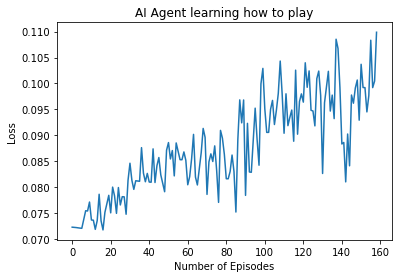

In [111]:
fig = plt.figure()
plt.plot( [i for i in range(len(agent_loss))], agent_loss)
plt.xlabel('Number of Episodes')
plt.ylabel('Loss')
plt.title('AI Agent learning how to play')

In [ ]:
np.savetxt('.//data4.csv', agent_loss, delimiter=',')

In [ ]:
def test(target_net, optimizer, f_path, device='cpu'):
    target_net, optimizer = load_ckp(f_path, policy_net, optimizer)
    target_net = policy_net.to(device)
    target_net.eval()
    action = 1
    environ.reset()
    environ.start()
    action = 1
    next_state, reward, done, score, highscore  = environ.take_action(action)
    state = next_state
    while True:
        q_values = target_net(state)
        action = torch.argmax(q_values)
        next_state, reward, done, score, highscore  = environ.take_action(action)
        state = next_state
        if done:
            environ.press_up()




In [ ]:
test(target_net, optimizer, './/saved_model/model2.pt', device)

In [ ]:
my_data1 = genfromtxt('.//data.csv', delimiter=',')
my_data2 = genfromtxt('.//data2.csv', delimiter=',')
my_data1 = np.append(my_data1, my_data2)
my_data3 = genfromtxt('.//data3.csv', delimiter=',')
my_data4 = genfromtxt('.//data4.csv', delimiter=',')
my_data1 = np.append(my_data1, my_data2)
plt.figure()    
plt.plot( [x for x in range(len(my_data1))], my_data1)


In [ ]:
np.exte

In [44]:
print(f"{environ.get_crashed()}")

True
